In [84]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima, ARIMA, model_selection
import numpy as np
from sklearn.model_selection import ParameterGrid

In [85]:
df = pd.read_csv(r'C:\Users\siddharth\Desktop\Python-Time-Series-Forecasting\Python - Time Series Forecasting\Time Series Analysis\ARIMA, SARIMA and SARIMAX\daily_revenue.csv')

In [86]:
df

,date,revenue,discount_rate,coupon_rate
0,1/1/2018,"6,270,839",34.27%,1.09%
1,2/1/2018,"8,922,076",30.87%,1.08%
2,3/1/2018,"8,446,101",28.11%,1.01%
3,4/1/2018,"7,785,798",27.32%,0.96%
4,5/1/2018,"6,375,303",25.70%,0.90%
...,...,...,...,...
1790,26/11/2022,"26,934,947",30.41%,0.38%
1791,27/11/2022,"31,890,868",29.75%,0.35%
1792,28/11/2022,"32,100,918",25.27%,8.93%
1793,29/11/2022,"14,314,613",19.54%,0.26%


In [4]:
df.set_index('date', inplace=True)

In [5]:
df = df.asfreq('D')

In [6]:
df['revenue'] = df['revenue'].str.replace(",","").astype(float)

In [7]:
df['discount_rate'] = df['discount_rate'].str.replace("%",'').astype(float)
df['coupon_rate'] = df['coupon_rate'].str.replace("%",'').astype(float)

In [8]:
df = df.rename(columns={'revenue':'y'})

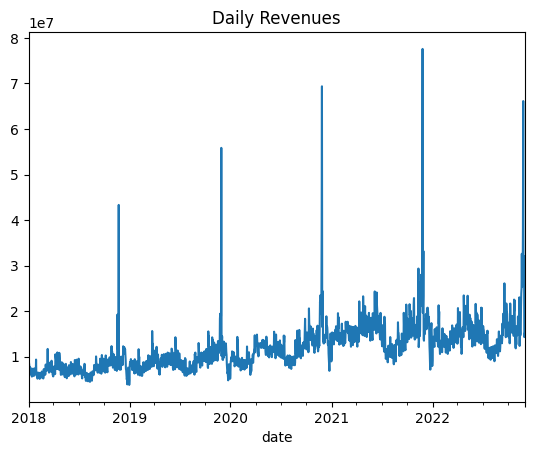

In [9]:
# Daily revenues line plot
df['y'].plot(title = 'Daily Revenues')
plt.show()

C:\Users\siddharth\AppData\Local\Temp\ipykernel_5364\2481325335.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_plot(df['y'].resample('M').mean(),


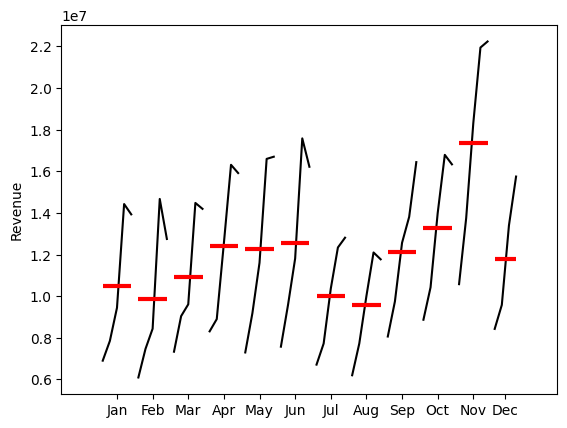

In [10]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of revenue values
month_plot(df['y'].resample('M').mean(),
           ylabel = 'Revenue')
plt.show()

C:\Users\siddharth\AppData\Local\Temp\ipykernel_5364\3193710253.py:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(df['y'].resample('Q').mean(),


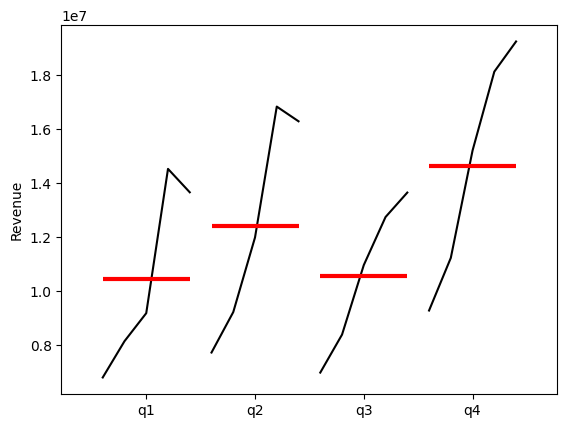

In [11]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of revenue values
# .resample('Q') - to convert the time series data into quarterly seasonality
quarter_plot(df['y'].resample('Q').mean(),
           ylabel = 'Revenue')
plt.show()

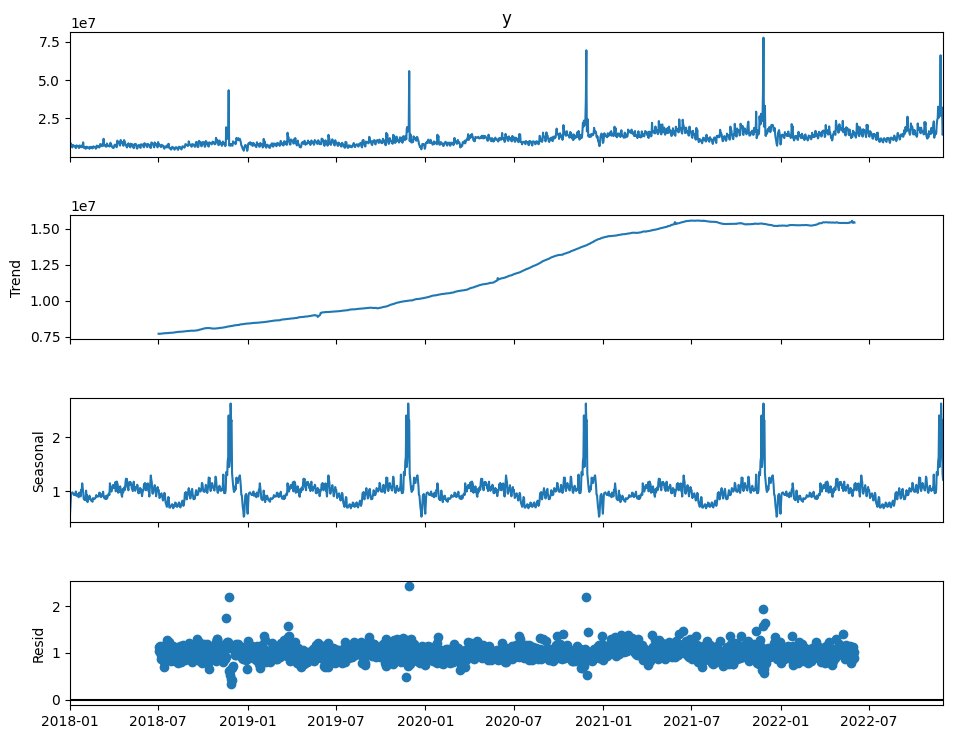

In [12]:
# Seasonal Decomposition Plots for Revenue Data
# Multiplicative model type, with daily seasonality (365 days)
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

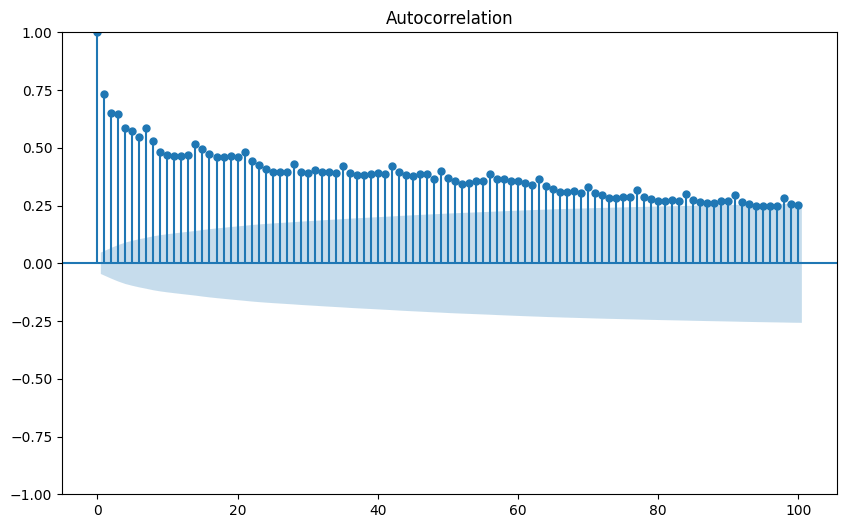

In [13]:
# Plot the autocorrelation (ACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

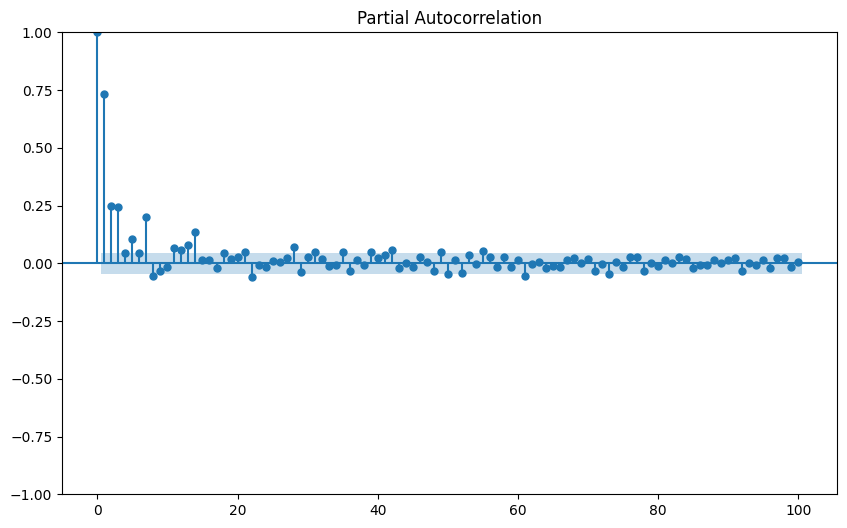

In [14]:
# Plot the partial autocorrelation (PACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

In [15]:
# null - time series is not stationary  

In [16]:
from statsmodels.tsa.stattools import adfuller 

result = adfuller(df['y']) 
print(f"{result[1]}")

if result[1] < 0.05: 
    print('Evidence Suggests that the time series is stationary') 
else: 
    print("Evidence suggests that the time series is not stationary")

0.10190360862386139
Evidence suggests that the time series is not stationary


In [17]:
df['y_diff'] = df['y'].diff().dropna()

In [18]:
df['y_diff']

date
2018-01-01           NaN
2018-01-02     2651237.0
2018-01-03     -475975.0
2018-01-04     -660303.0
2018-01-05    -1410495.0
                 ...    
2022-11-26   -39180777.0
2022-11-27     4955921.0
2022-11-28      210050.0
2022-11-29   -17786305.0
2022-11-30      712049.0
Freq: D, Name: y_diff, Length: 1795, dtype: float64

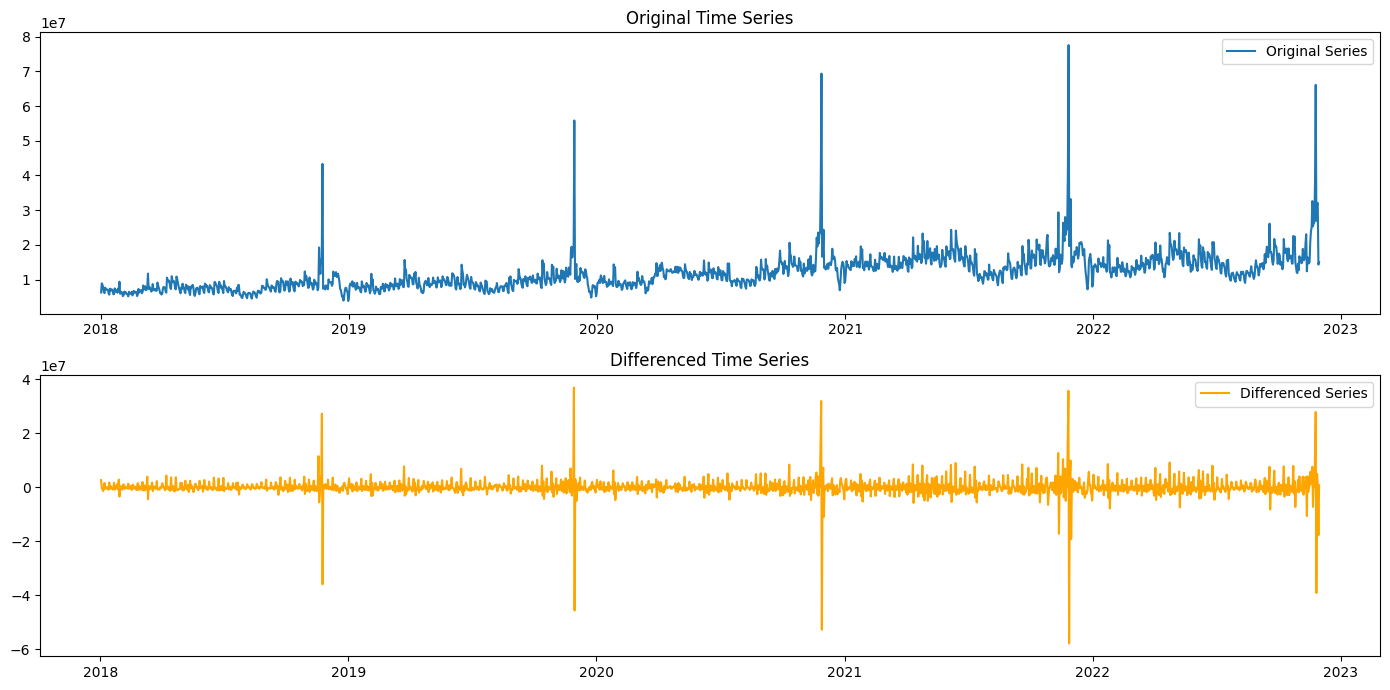

In [19]:
# Plotting the original and differenced series
# Set the size of the plot to 14 inches by 7 inches
plt.figure(figsize=(14, 7))

plt.subplot(2,1,1) 
plt.plot(df['y'], label = 'Original Series') 
plt.title('Original Time Series') 
plt.legend() 


plt.subplot(2,1,2)
plt.plot(df['y_diff'], label = 'Differenced Series', color = 'orange')
plt.title('Differenced Time Series') 
plt.legend() 


plt.tight_layout() 
plt.show()

In [20]:
result = adfuller(df['y_diff'].dropna()) 
print(f"{result[1]}")

if result[1] < 0.05: 
    print('Evidence Suggests that the time series is stationary') 
else: 
    print("Evidence suggests that the time series is not stationary")

6.513792026815736e-24
Evidence Suggests that the time series is stationary


In [21]:
## ARIMA Model 
df = df.dropna()

In [22]:
df

,y,discount_rate,coupon_rate,y_diff
date,,,,
2018-01-02,8922076.0,30.87,1.08,2651237.0
2018-01-03,8446101.0,28.11,1.01,-475975.0
2018-01-04,7785798.0,27.32,0.96,-660303.0
2018-01-05,6375303.0,25.70,0.90,-1410495.0
2018-01-06,6095418.0,25.02,0.87,-279885.0
...,...,...,...,...
2022-11-26,26934947.0,30.41,0.38,-39180777.0
2022-11-27,31890868.0,29.75,0.35,4955921.0
2022-11-28,32100918.0,25.27,8.93,210050.0


In [23]:
# Split the data into training and test 

test_days = 30 
train, test = df.iloc[:-test_days], df.iloc[-test_days:] 

In [24]:
model = auto_arima(train['y'], seasonal=False)

c:\Work\MLOps\flask_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Work\MLOps\flask_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Work\MLOps\flask_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Work\MLOps\flask_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Work\MLOps\flask_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Work\MLOps\f

In [25]:
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1764
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28800.439
Date:                Tue, 10 Jun 2025   AIC                          57616.879
Time:                        15:32:34   BIC                          57660.677
Sample:                    01-02-2018   HQIC                         57633.063
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4133      0.120     -3.438      0.001      -0.649      -0.178
ar.L2          0.3017      0.053      5.666      0.000       0.197       0.406
ar.L3          0.1574      0.028      5.719      0.000       0.103       0.211
ar.L4          0.0686      0.029      2.384      0.017       0.012       0.125
ar.L5          0.0475      0.024      1.976      0.048       0.000       0.095
ma.L1         -0.1607      0.118     -1.358      0.174      -0.393       0.071
ma.L2         -0.7418      0.108     -6.845      0.000      -0.954      -0.529
sigma2      9.089e+12   1.82e-14   4.99e+26      0.000    9.09e+12    9.09e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            582707.14
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.07   Skew:                             5.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.76e+42. Standard errors may be unstable.
"""

In [26]:
predictions_arima = model.predict(n_periods=len(test)) 
predictions_arima.shape

c:\Work\MLOps\flask_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(30,)

In [27]:
test.shape

(30, 4)

In [28]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = root_mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

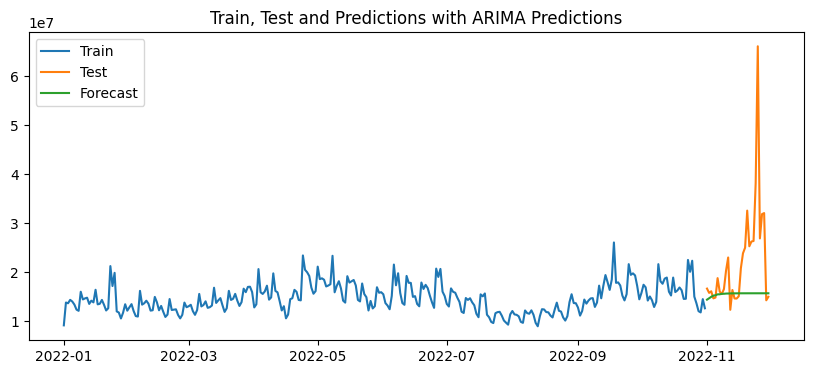

The MAE is 7268062.38
The RMSE is 12366738.60
The MAPE is 24.15 %


In [29]:
model_assessment(train['y'].loc['2022':], test['y'], predictions_arima,'ARIMA Predictions');

## SARIMA

In [30]:
model_sarima = auto_arima(train['y'], n_jobs=-1, m = 7)
model_sarima.summary()

c:\Work\MLOps\flask_env\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Work\MLOps\flask_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Work\MLOps\flask_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Work\MLOps\flask_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Work\MLOps\flask_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1764
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28745.263
Date:                           Tue, 10 Jun 2025   AIC                          57512.527
Time:                                   15:33:45   BIC                          57572.749
Sample:                               01-02-2018   HQIC                         57534.781
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.018e+04   4740.487      2.148      0.032     893.697    1.95e+04
ar.L1         -0.3483      0.073     -4.789      0.000      -0.491      -0.206
ar.L2          0.1853      0.033      5.701      0.000       0.122       0.249
ar.L3          0.1033      0.016      6.527      0.000       0.072       0.134
ma.L1         -0.1958      0.074     -2.646      0.008      -0.341      -0.051
ma.L2         -0.5678      0.061     -9.358      0.000      -0.687      -0.449
ar.S.L7        0.0785      0.183      0.429      0.668      -0.280       0.437
ar.S.L14       0.8726      0.174      5.020      0.000       0.532       1.213
ma.S.L7       -0.0016      0.178     -0.009      0.993      -0.351       0.348
ma.S.L14      -0.8324      0.159     -5.247      0.000      -1.143      -0.521
sigma2      9.299e+12      0.000   8.62e+16      0.000     9.3e+12     9.3e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            852478.78
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.88   Skew:                             5.25
Prob(H) (two-sided):                  0.00   Kurtosis:                       110.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.92e+30. Standard errors may be unstable.
"""

In [31]:
predictions_sarima = model_sarima.predict(n_periods=len(test))

c:\Work\MLOps\flask_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


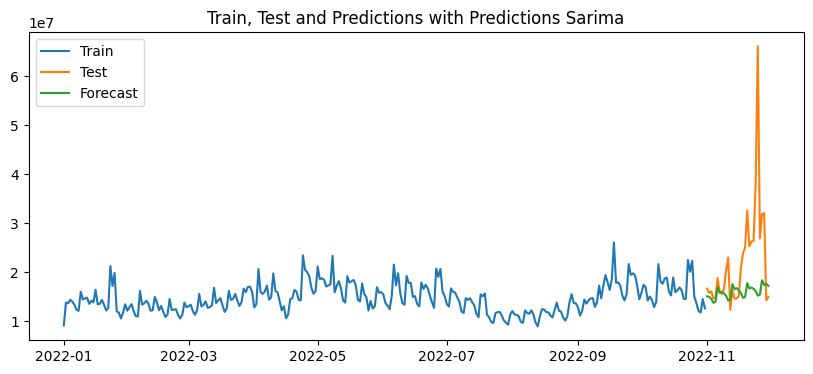

The MAE is 7211463.37
The RMSE is 12154356.07
The MAPE is 24.54 %


In [32]:
model_assessment(train['y']['2022':], test['y'], predictions_sarima,'Predictions Sarima')

## SARIMAX 

In [33]:
import warnings
warnings.filterwarnings("ignore")

In [34]:
# Split the data into training and test 

test_days = 30 
exog_train, exog_test = df.iloc[:-test_days,1:3], df.iloc[-test_days:,1:3] 

exog = df.iloc[:,1:3]

In [35]:
model_sarimax = auto_arima(train['y'], n_jobs=-1, m = 7,X = exog_train)
model_sarimax.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1764
Model:             SARIMAX(4, 1, 4)x(1, 0, [1], 7)   Log Likelihood              -28594.034
Date:                             Tue, 10 Jun 2025   AIC                          57216.068
Time:                                     15:36:38   BIC                          57292.715
Sample:                                 01-02-2018   HQIC                         57244.391
                                      - 10-31-2022                                         
Covariance Type:                               opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.904e+04    1.1e+04      1.738      0.082   -2436.535    4.05e+04
discount_rate  4.049e+05   2.29e+04     17.709      0.000     3.6e+05     4.5e+05
coupon_rate    9.221e+05   3075.496    299.822      0.000    9.16e+05    9.28e+05
ar.L1            -2.2015      0.229     -9.593      0.000      -2.651      -1.752
ar.L2            -1.7467      0.365     -4.790      0.000      -2.461      -1.032
ar.L3            -0.3118      0.137     -2.273      0.023      -0.581      -0.043
ar.L4             0.2055      0.049      4.216      0.000       0.110       0.301
ma.L1             1.6556      0.230      7.212      0.000       1.206       2.106
ma.L2             0.3954      0.250      1.579      0.114      -0.095       0.886
ma.L3            -0.9763      0.133     -7.353      0.000      -1.237      -0.716
ma.L4            -0.6839      0.159     -4.308      0.000      -0.995      -0.373
ar.S.L7           0.9843      0.010    100.814      0.000       0.965       1.003
ma.S.L7          -0.9319      0.021    -44.657      0.000      -0.973      -0.891
sigma2         7.899e+12      0.004   2.15e+15      0.000     7.9e+12     7.9e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1111476.87
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             5.65
Prob(H) (two-sided):                  0.00   Kurtosis:                       125.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+29. Standard errors may be unstable.
"""

In [36]:

predictions_sarimax = model_sarimax.predict(n_periods=len(test), X = exog_test)

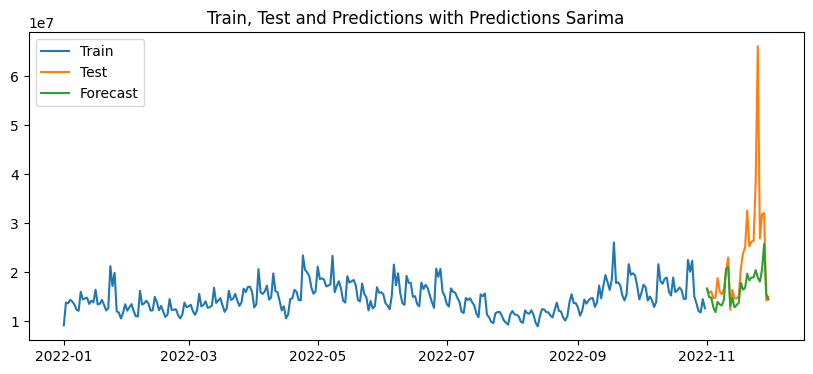

The MAE is 5810258.53
The RMSE is 10501651.74
The MAPE is 19.70 %


In [37]:
model_assessment(train['y']['2022':], test['y'], predictions_sarimax,'Predictions Sarima')

## Cross Validation 

## Define a model to do cross validation 

In [38]:
model_cv = ARIMA(order=(2,1,2), seasonal_order=(2,0,2,7))

In [39]:
cv = model_selection.RollingForecastCV(h=30, step=15, initial=df.shape[0] - 180)

In [40]:
cv

RollingForecastCV(h=30, initial=1614, step=15)

In [41]:
cv_score = model_selection.cross_val_score(
    estimator=model_cv, y=df["y"], X=exog, scoring="mean_squared_error", verbose=1000, cv = cv
)

[CV] fold=0 ..........................................................
fold=0, score=11499692823306.211 [time=4.240 sec]
[CV] fold=1 ..........................................................
fold=1, score=13766812230769.494 [time=3.879 sec]
[CV] fold=2 ..........................................................
fold=2, score=11817773563471.166 [time=4.255 sec]
[CV] fold=3 ..........................................................
fold=3, score=1170198510680.112 [time=3.828 sec]
[CV] fold=4 ..........................................................
fold=4, score=842628186815.063 [time=3.938 sec]
[CV] fold=5 ..........................................................
fold=5, score=7220574699561.496 [time=3.593 sec]
[CV] fold=6 ..........................................................
fold=6, score=12408286211959.834 [time=3.811 sec]
[CV] fold=7 ..........................................................
fold=7, score=5885740665578.707 [time=4.336 sec]
[CV] fold=8 .........................

In [42]:
cv_score

array([1.14996928e+13, 1.37668122e+13, 1.18177736e+13, 1.17019851e+12,
       8.42628187e+11, 7.22057470e+12, 1.24082862e+13, 5.88574067e+12,
       2.99101696e+13, 1.10273365e+13, 1.08239007e+14])

In [43]:
rmse = np.sqrt(np.mean(cv_score))

print(f"The cross validation rmse is {rmse}")

The cross validation rmse is 4408547.692157556


## Parameter Tuning 

In [44]:
param_grid = {
    "p": [1, 2, 3],
    "d": [0, 1],
    "q": [1, 2, 3],
    "P": [1, 2],
    "D": [0],
    "Q": [1, 2],
    'm': [7,12]
}

grid = list(ParameterGrid(param_grid))[:3]

In [45]:
from tqdm.auto import tqdm 

In [46]:
# Parameter Tuning Loop

rmse_list = []

for params in tqdm(grid):

    # Build the model with set of params
    model_cv = ARIMA(
        order=(params["p"], params["d"], params["q"]),
        seasonal_order=(params["P"], params["D"], params["Q"], params["m"]),
    )

    # Evaluate the model
    cv = model_selection.RollingForecastCV(h=30, step=15, initial=df.shape[0] - 180)
    cv_score = model_selection.cross_val_score(
        estimator=model_cv,
        y=df["y"],
        X=exog,
        scoring="mean_squared_error",
        verbose=1000,
        cv=cv,
    )

    rmse = np.sqrt(np.mean(cv_score))

    # Store the model

    rmse_list.append(rmse)

  0%|          | 0/3 [00:00<?, ?it/s]

[CV] fold=0 ..........................................................
fold=0, score=6497543706540.314 [time=0.537 sec]
[CV] fold=1 ..........................................................
fold=1, score=14557199441789.023 [time=0.492 sec]
[CV] fold=2 ..........................................................
fold=2, score=14539988302100.279 [time=0.475 sec]
[CV] fold=3 ..........................................................
fold=3, score=7396786486991.533 [time=0.509 sec]
[CV] fold=4 ..........................................................
fold=4, score=6309788023662.135 [time=0.477 sec]
[CV] fold=5 ..........................................................
fold=5, score=2755785616460.343 [time=0.525 sec]
[CV] fold=6 ..........................................................
fold=6, score=14878183365632.305 [time=0.493 sec]
[CV] fold=7 ..........................................................
fold=7, score=9117441434699.812 [time=0.493 sec]
[CV] fold=8 .........................

In [47]:
rmse_list

[4064259.817883231, 4046433.587021134, 4047463.7638395526]

In [48]:
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse_list

In [49]:
tuning_results

,D,P,Q,d,m,p,q,rmse
0,0,1,1,0,7,1,1,4.064260e+06
1,0,1,1,0,7,1,2,4.046434e+06
2,0,1,1,0,7,1,3,4.047464e+06


In [50]:
best_params = tuning_results.iloc[tuning_results['rmse'].idxmin()]

In [55]:
y = df['y']

X = df.iloc[:,1:3]

In [60]:
params = best_params.astype(int).to_dict()

In [ ]:
p, d, q, P, D, Q, m = (
    params["p"],
    params["d"],
    params["q"],
    params["P"],
    params["D"],
    params["Q"],
    params["m"],
)

In [74]:
df_future = pd.read_csv(r'C:\Users\siddharth\Desktop\Python-Time-Series-Forecasting\Python - Time Series Forecasting\Time Series Analysis\ARIMA, SARIMA and SARIMAX\future_regressors.csv')
df_future['date'] = pd.to_datetime(df_future['date'], format = "%d/%m/%Y")
df_future.set_index('date', inplace=True)

In [75]:
X_future = df_future.iloc[:,1:3] * 100

In [78]:
tuned_models = ARIMA(
    order= (p,d,q), 
    seasonal_order=(P,D,Q,m)
)

tuned_models.fit(y,X)

ARIMA(order=(1, 0, 2), seasonal_order=(1, 0, 1, 7))

In [80]:
predictions = tuned_models.predict(n_periods=len(X_future), X = X_future)

In [81]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

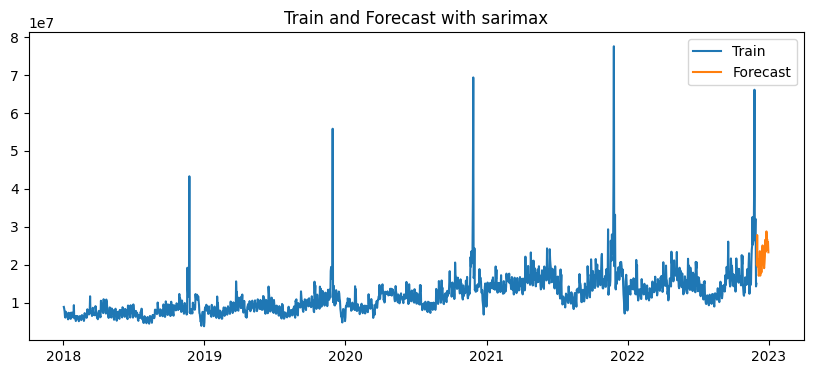

In [83]:
plot_future(y,predictions,'sarimax')